# 1. Convert Sentinel-2 Grid KML to Geoparquet

The official Sentinel-2 grid is sourced from this ~100MB KML file:
https://sentinel.esa.int/documents/247904/1955685/S2A_OPER_GIP_TILPAR_MPC__20151209T095117_V20150622T000000_21000101T000000_B00.kml 

The following notebook converts this file to the cloud-native file format [GeoParquet](https://github.com/opengeospatial/geoparquet) for easier visualization and batch processing of other datasets.

In [ ]:
import requests
import zipfile
from io import BytesIO

import pandas as pd
import geopandas as gpd
import shapely
from shapely import wkt, Point, MultiPolygon
import utils
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
# Load KML file directly from URL
# download the zip
resp = requests.get(utils.URL_ESA_S2_GRID_KML)
resp.raise_for_status()

# read zip in memory
zf = zipfile.ZipFile(BytesIO(resp.content))

# find KML inside
print(zf.namelist())
kml_name = next(name for name in zf.namelist() if name.lower().endswith(".kml"))

# read the KML file as bytes
kml_bytes = zf.read(kml_name)

gdf = gpd.read_file(
    BytesIO(kml_bytes),
    engine="pyogrio",
    force_2d=True,
)
gdf = gdf.rename(columns={"Name": "tile"})

gdf.head()

,tile,description,geometry
0,01CCV,TILE PROPERTIES<br><table border=0 cellpadding...,GEOMETRYCOLLECTION (POLYGON ((180.00000 -73.05...
1,01CDH,TILE PROPERTIES<br><table border=0 cellpadding...,GEOMETRYCOLLECTION (POLYGON ((180.00000 -83.80...
2,01CDJ,TILE PROPERTIES<br><table border=0 cellpadding...,GEOMETRYCOLLECTION (POLYGON ((180.00000 -82.91...
3,01CDK,TILE PROPERTIES<br><table border=0 cellpadding...,GEOMETRYCOLLECTION (POLYGON ((180.00000 -82.01...
4,01CDL,TILE PROPERTIES<br><table border=0 cellpadding...,GEOMETRYCOLLECTION (POLYGON ((180.00000 -81.12...


In [ ]:
# GEOMETRYCOLLECTION contains polygon and centroid. If polygons cross antimeridian split into 2
gdf['geometry'] = gdf.geometry.apply(lambda x: MultiPolygon([g for g in x.geoms if not isinstance(g, Point)]))

# Extract UTM_WKT and EPSG from "Description" column
gdf['epsg'] = gdf.apply(utils.get_epsg, axis=1)
gdf['utm_wkt'] = gdf.apply(utils.get_utm_wkt, axis=1)

# Drop description column 
gdf = gdf.drop(columns=['Description'])
gdf.head()

,tile,geometry,epsg,utm_wkt
0,01CCV,"POLYGON ((180.00000 -73.05974, 176.86462 -72.9...",32701,"POLYGON ((300000 2000020,300000 1890220,409800..."
1,01CDH,"POLYGON ((180.00000 -83.80855, 174.71288 -83.7...",32701,"POLYGON ((399960 800020,399960 690220,509760 6..."
2,01CDJ,"POLYGON ((180.00000 -82.91344, 175.74819 -82.8...",32701,"POLYGON ((399960 900040,399960 790240,509760 7..."
3,01CDK,"POLYGON ((180.00000 -82.01866, 176.55270 -81.9...",32701,"POLYGON ((399960 1000000,399960 890200,509760 ..."
4,01CDL,"POLYGON ((180.00000 -81.12317, 177.19616 -81.1...",32701,"POLYGON ((399960 1100020,399960 990220,509760 ..."


In [ ]:
# Add simple UTM bounds (left, down, right, up)
gdf[["utm_left", "utm_down", "utm_right", "utm_up"]] = (
    gdf["utm_wkt"]
    .apply(lambda x: wkt.loads(x).bounds)
    .apply(pd.Series)
)

In [5]:
print(f"Number of tiles: {len(gdf)}")
gdf.to_parquet("sentinel-2-grid.parquet")

Number of tiles: 56686


## 1.1 Only keep tiles that intersect with land areas

<Axes: >

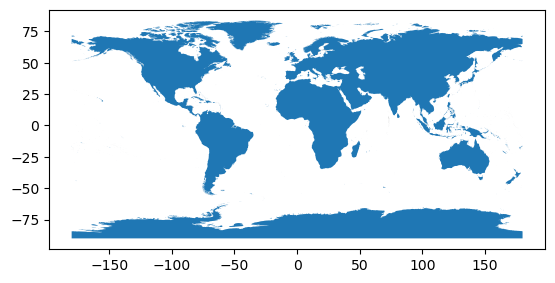

In [ ]:
# Load high resolution land mask
resp = requests.get(utils.URL_NE_VEC_10m_LAND_GEOJSON)
resp.raise_for_status()
land_highres = gpd.read_file(BytesIO(resp.content), engine="pyogrio")
land_highres = gpd.read_file(utils.URL_NE_VEC_10m_LAND_GEOJSON, engine="pyogrio")
land_highres = land_highres.to_crs(epsg=4326)  # ensure WGS 84
land_highres = shapely.union_all(land_highres.geometry)
shapely.prepare(land_highres)
land_highres.plot()

In [ ]:
%%time 
geoms = GeometryArray(np.array([g for g in gdf.geometry]))
land = union_query_strtree(shapely.STRtree(geoms), land_highres)
gdf_land = gdf.iloc[land]
gdf_land.head()

CPU times: user 7min 39s, sys: 3min 31s, total: 11min 10s
Wall time: 2min 32s


,tile,geometry,epsg,utm_wkt,utm_bounds
0,01CEH,"POLYGON ((-177.00144 -82.85238, -169.14642 -82...",32701,"POLYGON ((499980 800020,499980 690220,609780 6...","(499980.0, 690220.0, 609780.0, 800020.0)"
1,01CEJ,"POLYGON ((-177.00128 -81.95638, -170.00719 -81...",32701,"POLYGON ((499980 900040,499980 790240,609780 7...","(499980.0, 790240.0, 609780.0, 900040.0)"
2,01FBE,"POLYGON ((180.00000 -50.59941, 178.76332 -50.5...",32701,"POLYGON ((199980 4500040,199980 4390240,309780...","(199980.0, 4390240.0, 309780.0, 4500040.0)"
3,01FBF,"POLYGON ((180.00000 -49.70001, 178.84184 -49.6...",32701,"POLYGON ((199980 4600000,199980 4490200,309780...","(199980.0, 4490200.0, 309780.0, 4600000.0)"
4,01GBH,"POLYGON ((180.00000 -47.89995, 178.98771 -47.8...",32701,"POLYGON ((199980 4800040,199980 4690240,309780...","(199980.0, 4690240.0, 309780.0, 4800040.0)"


In [ ]:
print(f"Number of tiles: {len(gdf_land)}")
gdf_land.to_parquet("sentinel-2-grid_LAND.parquet")

Number of tiles: 20430
